# 인트로

- 0 : T-shirt/top

- 1 : Trouser

- 2 : Pullover

- 3 : Dress

- 4 : Coat

- 5 : Sandal

- 6 : Shirt

- 7 : Sneaker

- 8 : Bag

- 9 : Ankle boot

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

# 1.데이터 불러오기

In [13]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]
submission = pd.read_csv('sample_submission.csv')

display(train)
display(test)
display(submission)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,37,...,32,23,14,20,0,0,1,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0


In [ ]:
print(train.info())
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 59.8 MB
None


# 2.데이터 형태 변경

In [ ]:
# 실수형으로 변환
X = np.array(train.drop('label', axis = 1), dtype = 'float32')
# y = train.label
target = np.array(test, dtype='float32')
display(X)
y = train.label
display(y)
target = np.array(test, dtype='float32')
display(target)
# 케라스는 0~1 사이의 값으로 구동시킬때 성능이 좋으므로
# 255로 나눠 정규화
X /= 255
target /= 255

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

5번 클래스 의류


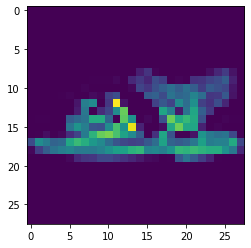

In [ ]:
# 샘플 출력
image = X[2022,:].reshape(28,28)
print(f'{int(y[2022])}번 클래스 의류')
plt.imshow(image)
plt.show()

In [ ]:
# 28,28,1로 지정
X = X.reshape(-1, 28, 28, 1)
target = target.reshape(-1, 28, 28, 1)
# 랜덤 시드 설정
np.random.seed(120)

# 3.딥러닝



### StratifiedKFold
- kfold가 치우쳐서 학습하는 단점을 해결하기 위해 사용한다.
- StratifiedKFold는 타겟에 속성값의 갯수를 동일하게 가져감으로 kfold처럼 데이터가 몰리는 것을 막아줌

### ReduceLROnPlateau는 콜백 함수
- 모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도하는 콜백함수

In [ ]:
skf = StratifiedKFold(n_splits = 15, random_state = 1011, shuffle = True)
reLR = ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.5) # 학습률 조정
es = EarlyStopping(patience = 5, verbose=1, monitor = 'val_acc', mode = 'max') # 학습 조기 종료

In [ ]:
sub_pred = np.zeros((test.shape[0], 10))
print(sub_pred.shape)

for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)) :
  print('=' * 25)
  print(f'{i + 1}번째 학습 FOLD 학습 시작')
    
  tr_x, tr_y = X[tr_idx], y[tr_idx] # 학습데이터
  val_x, val_y = X[val_idx], y[val_idx] # 검증데이터

# 모델을 저장할 때 사용되는 콜백함수
  mc = ModelCheckpoint(f'cv_study{i + 1}.h5',save_best_only=True, verbose=1, monitor = 'val_acc', mode = 'max', save_weights_only=True)

  model = Sequential()

  model.add(Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))  # 컨볼루션 레이어 , 여기서 padding : 경계 처리 방법이며‘same'는 출력 이미지 사이즈가 입력 이미지 사이즈와 동일
  model.add(BatchNormalization())  #  변형된 분포가 나오지 않도록 조절
  # https://eehoeskrap.tistory.com/430
  model.add(Dropout(0.3))  # 과대적합(Overfitting)을 방지하기 위해 사용
  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3))) # 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만들어 사소한 변화가 영향을 미치지 않도록 함
  model.add(Dropout(0.3))
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3)))
  model.add(Dropout(0.3))
  model.add(Flatten()) # 2차원 배열을 1차원으로 바꿔줌
  model.add(Dense(128,activation='relu')) # 은닉층 128개
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(10,activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer = RMSprop(lr=0.003),metrics=['acc'])
  # https://ahnjg.tistory.com/88

  history = model.fit(tr_x, tr_y, epochs = 1000, 
                      validation_data = (val_x, val_y), callbacks = [es, mc, reLR])

  model.load_weights(f'cv_study{i + 1}.h5')

  pred = model.predict(target) / 15
  sub_pred += pred
  print(f'{i + 1}번째 학습 FOLD 학습 완료\n')

1번째 학습 FOLD 학습 시작
Epoch 1/1000
1750/1750 [==============================] - ETA: 0s - loss: 0.5537 - acc: 0.8036
Epoch 1: val_acc improved from -inf to 0.88250, saving model to cv_study1.h5
1750/1750 [==============================] - 20s 11ms/step - loss: 0.5537 - acc: 0.8036 - val_loss: 0.3363 - val_acc: 0.8825 - lr: 0.0030
Epoch 2/1000
1749/1750 [============================>.] - ETA: 0s - loss: 0.3630 - acc: 0.8755
Epoch 2: val_acc did not improve from 0.88250
1750/1750 [==============================] - 18s 10ms/step - loss: 0.3630 - acc: 0.8755 - val_loss: 0.3291 - val_acc: 0.8808 - lr: 0.0030
Epoch 3/1000
1747/1750 [============================>.] - ETA: 0s - loss: 0.3187 - acc: 0.8902
Epoch 3: val_acc improved from 0.88250 to 0.90800, saving model to cv_study1.h5
1750/1750 [==============================] - 18s 10ms/step - loss: 0.3187 - acc: 0.8903 - val_loss: 0.2458 - val_acc: 0.9080 - lr: 0.0030
Epoch 4/1000
1749/1750 [============================>.] - ETA: 0s - loss: 0.2943

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_157 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_210 (Ba  (None, 28, 28, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_117 (Dropout)       (None, 28, 28, 64)        0         
                                                                 
 conv2d_158 (Conv2D)         (None, 28, 28, 32)        18464     
                                                                 
 batch_normalization_211 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_159 (Conv2D)         (None, 28, 28, 32)      

# 4. 답안지 작성

In [ ]:
submission['label'] = [np.argmax(x) for x in sub_pred] # 각 클래스별 확률에서 제일 높은 확률의 클래스 할당
#여기서 np.argmax는 최댓값의 인덱스 값
submission.to_csv('cv_study.csv', index = False)

# 5. 신경망 재설정

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 11, shuffle = True)
reLR = ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.5) # 학습률 조정
es = EarlyStopping(patience = 5, verbose=1, monitor = 'val_acc', mode = 'max') # 학습 조기 종료

In [ ]:
sub_pred = np.zeros((test.shape[0], 10))  # (10000, 10)의 0으로 채워진 배열 생성
# print(sub_pred)

for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)): #여기서 X는 학습 데이터, y는 라벨
  print('=' * 300)
  print(f'{i + 1}번째 학습 FOLD 학습 시작')
#   print(tr_idx, '\t', val_idx)

  # 학습데이터
  tr_x, tr_y = X[tr_idx], y[tr_idx]
#   print(tr_x, '\t', tr_y)
  # 검증데이터
  val_x, val_y = X[val_idx], y[val_idx]
#   print(val_x, '\t', val_y)
#   print(val_x.shape, '\t', val_y.shape)

#    체크포인트, 모델 가중치 항상 저장
  mc = ModelCheckpoint(f'cv_restudy{i + 1}.h5',save_best_only=True, verbose=1, save_weights_only=True)

  model = Sequential()

  model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))  #Conv2D는 컨벌루션 층, 함수는 렐루
  model.add(BatchNormalization()) #각 레이어마다 정규화 하는 레이어를 두어, 변형된 분포가 나오지 않도록 조절하게 하는 것이 배치 정규화
  model.add(Dense(64,activation='relu'))  # 은닉층 128개
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv2D(128,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(128,activation='relu'))  # 은닉층 128개
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3)))
#   model.add(Dropout(0.3))  # 30% 노드를 끔
  model.add(Dense(128,activation='relu'))  # 은닉층 128개
  model.add(BatchNormalization())
#   model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
#   model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5),activation='relu'))
  model.add(BatchNormalization())
#   model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D((3,3)))
#   model.add(Dropout(0.3))
#   model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
#   model.add(BatchNormalization())
#   model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
#   model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3)))  # 구역 안에서 최댓값을 뽑아내는 풀링 기법
#   model.add(Dropout(0.3))
  model.add(Flatten())  # 2차원 배열을 1차원으로 바꿔줌
#   model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(32,activation='relu'))
  model.add(BatchNormalization())
#   model.add(Dropout(0.2))
  model.add(Dense(10,activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer = RMSprop(lr=0.2), metrics=['acc'])

  history = model.fit(tr_x, tr_y, epochs = 500, 
                      validation_data = (val_x, val_y), callbacks = [es, mc, reLR])

  model.load_weights(f'cv_restudy{i + 1}.h5')

  pred = model.predict(target) / 5
  sub_pred += pred
  print(f'{i + 1}번째 학습 FOLD 학습 완료\n')
  print("="*300)

 432/1500 [=======>......................] - ETA: 6:47 - loss: 0.4943 - acc: 0.8696

KeyboardInterrupt: ignored

In [ ]:
model.summary()

In [ ]:
submission['label'] = [np.argmax(x) for x in sub_pred] # 각 클래스별 확률에서 제일 높은 확률의 클래스 할당
#여기서 np.argmax는 최댓값의 인덱스 값
submission.to_csv('cv_restudy.csv', index = False)
submission

## 혼공머신 책 참고

In [14]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]
submission = pd.read_csv('sample_submission.csv')

display(train)
display(test)
display(submission)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,37,...,32,23,14,20,0,0,1,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0


In [35]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

train_input = train.iloc[:, :]
train_target = train.iloc[:, 0]

print(train_input.shape, train_target.shape)

train_scaled = np.array(train.drop('label', axis = 1), dtype = 'float32')
print(train_scaled)
train_scaled = train_scaled.reshape(-1, 28, 28, 1) / 255.0
print(train_scaled.shape, train_target.shape)

target = np.array(test, dtype='float32')
target /= 255
target = target.reshape(-1, 28, 28, 1)

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=102)

(60000, 785) (60000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 28, 28, 1) (60000,)


In [36]:
# from tensorflow import keras
# from sklearn.model_selection import train_test_split

# (train_input, train_target), (test_input, test_target) = \
#     keras.datasets.fashion_mnist.load_data()

# train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# print(train_scaled.shape, train_target.shape)
# train_scaled, val_scaled, train_target, val_target = train_test_split(
#     train_scaled, train_target, test_size=0.2, random_state=42)

In [37]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(64, kernel_size=(5,5), activation='relu', 
                              padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dense(20, activation='relu'))
model.add(BatchNormalization())
# model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

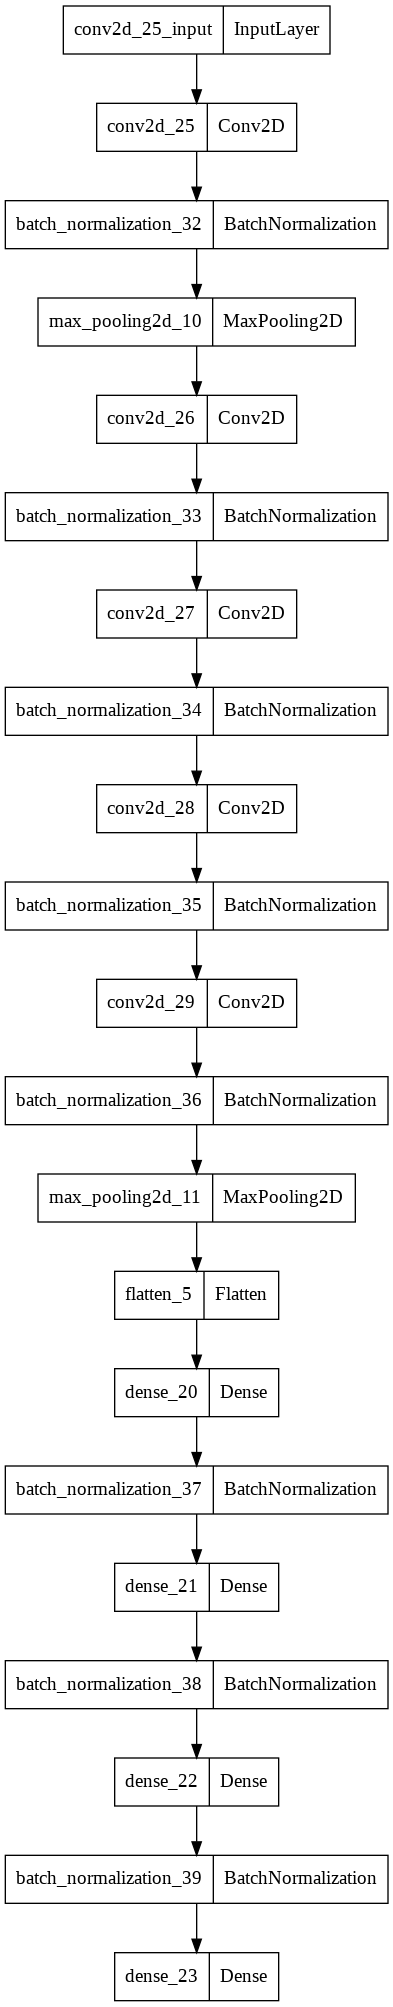

In [38]:
keras.utils.plot_model(model)

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 12s 7ms/step - loss: 0.4650 - accuracy: 0.8456 - val_loss: 0.4254 - val_accuracy: 0.8556
Epoch 2/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2963 - accuracy: 0.8949 - val_loss: 0.2717 - val_accuracy: 0.8997
Epoch 3/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2580 - accuracy: 0.9098 - val_loss: 0.2507 - val_accuracy: 0.9086
Epoch 4/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2296 - accuracy: 0.9179 - val_loss: 0.2608 - val_accuracy: 0.9039
Epoch 5/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2075 - accuracy: 0.9270 - val_loss: 0.3202 - val_accuracy: 0.8836


In [28]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2349 - accuracy: 0.9144


[0.2349063754081726, 0.9144166707992554]

In [ ]:
preds = model.predict(target)
print(preds)

[[9.9559397e-01 2.2685403e-07 9.8214706e-04 ... 4.8951479e-04
  6.7665751e-05 2.6917731e-05]
 [8.7972074e-07 9.9997938e-01 8.5686565e-07 ... 1.4563869e-06
  9.3709389e-07 8.3320077e-07]
 [2.3628304e-02 3.8837412e-04 4.2616335e-01 ... 1.0499885e-05
  3.2728261e-04 2.8027853e-05]
 ...
 [5.7515704e-06 3.6829570e-06 4.6131525e-05 ... 4.5564884e-06
  9.9990702e-01 4.5357428e-06]
 [5.7211651e-07 3.1853469e-07 1.7562650e-06 ... 1.2591564e-06
  9.9998391e-01 4.0578675e-06]
 [2.6027060e-06 9.9991643e-01 2.5867059e-06 ... 1.3268125e-07
  4.6892990e-05 1.4779348e-05]]


In [ ]:
submission['label'] = [np.argmax(x) for x in preds] # 각 클래스별 확률에서 제일 높은 확률의 클래스 할당
#여기서 np.argmax는 최댓값의 인덱스 값
submission.to_csv('result2.csv', index = False)
submission

,index,label
0,0,0
1,1,1
2,2,6
3,3,2
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8


## 참고 사이트
- https://github.com/rickiepark/hg-mldl/blob/master/8-2.ipynb
- https://dacon.io/competitions/open/235594/codeshare/2297?page=1&dtype=recent
